# Exploration01 - 인공지능과 가위바위보 하기

가위, 바위, 보를 인식하는 이미지 분류기를 만들어보자

---

### 루브릭 평가 기준

1. 분류기 모델 성공 - 트레이닝이 정상적으로 수행됐나
2. 오버피팅 극복을 위한 시도 - 데이터셋의 다양성, 정규화 등 시도가 적절했나
3. test accuracy - 60% 이상 도달했나

---

### 목차

0. 필요 모듈 import


1. 데이터셋
  - 데이터 구성
  - 이미지 사이즈 조정
  - 데이터 로드
  - 클래스 리스트
  - 이미지 확인
    

2. 모델
  - 네트워크 설계
  - 학습


3. 결과 확인
  - 모델 평가
  - 잘못 예측한 경우


4. 재학습
  - 하이퍼파라미터 조정
  - 레이어 추가
  - 이미지 원본 사용


5. 회고


6. 참고 자료

## 0. 필요 모듈 import

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image

## 1. 데이터셋

### - 데이터 구성  

혼자서 4000장 가까이 되는 사진을 모두 준비하는 것은 너무 힘들기 때문에 동료들의 도움으로 완성했다.  
내가 찍은 사진은 테스트 데이터로 사용하고, 동료들이 함께 만들어준 사진은 학습에 사용했다.

Train Data : 각 클래스마다 1100장, 총 3300장  
Test Data : 각 클래스마다 200장, 총 600장

### - 이미지 사이즈 조정

노드 학습 내용 중 MNIST 데이터를 분류하는 모델을 그대로 사용하려고 한다.  
모델의 input shape에 맞추어 이미지를 resize 하자!

In [2]:
def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg") 
    target_size=(28,28)
    
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
        
    print(len(images), " images resized.")

1. img_path에 있는 jpg 확장자의 파일을 모두 불러와 images에 담는다.  
2. 타겟 사이즈를 정해준다.
3. images에서 한 장씩 꺼내서 반복한다.
4. 원본이미지를 불러와 old_img에 담는다.
5. old_img를 resize하여 new_img에 담는다.
6. new_img를 저장한다.  


* ANTIALIAS는 뭐지?  
    높은 해상도의 신호를 낮은 해상도로 나타낼 때 생기는 깨짐을 최소화하는 방법이다.

In [3]:
dataset_dir_path = os.getcwd() + "/dataset"
test_dir_path = os.getcwd() + "/test"

In [4]:
#가위 이미지 resize
resize_images(dataset_dir_path + '/scissors')
print("가위 Train 이미지 resize 완료!")
resize_images(test_dir_path + '/scissors')
print("가위 Test 이미지 resize 완료!")
print("-"*25)

#바위 이미지 resize
resize_images(dataset_dir_path + '/rock')
print("바위 Train 이미지 resize 완료!")
resize_images(test_dir_path + '/rock')
print("바위 Test 이미지 resize 완료!")
print("-"*25)

#보 이미지 resize
resize_images(dataset_dir_path + '/paper')
print("보 Train 이미지 resize 완료!")
resize_images(test_dir_path + '/paper')
print("보 Test 이미지 resize 완료!")

1100  images resized.
가위 Train 이미지 resize 완료!
200  images resized.
가위 Test 이미지 resize 완료!
-------------------------
1100  images resized.
바위 Train 이미지 resize 완료!
200  images resized.
바위 Test 이미지 resize 완료!
-------------------------
1100  images resized.
보 Train 이미지 resize 완료!
200  images resized.
보 Test 이미지 resize 완료!


### - 데이터 로드

학습에 사용될 수 있도록 이미지와 라벨을 행렬로 불러온다.  
라벨은 가위는 0, 바위는 1, 보자기는 2로 넣어준다.

In [5]:
def load_data(img_path, image_size, number_of_data):

    img_size = image_size
    color = 3
    
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32) 
    
    idx = 0

    for file in glob.iglob(img_path+'/scissors/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=2   # 보 : 2
        idx=idx+1
    
    return imgs, labels


1. 전체 이미지 데이터를 담을 수 있는 행렬을 생성한다. (데이터 수 * 이미지 크기 * 이미지 크기 * RGB)
2. 전체 데이터 라벨을 담을 수 있는 행렬을 생성한다. (데이터 수)
3. 반복문들 돌며 전체 데이터를 담은 행렬을 반환한다.

In [6]:
dataset_dir_path = os.getcwd() + "/dataset"
test_dir_path = os.getcwd() + "/test"

(x_train, y_train) = load_data(dataset_dir_path, 28, 3300)
(x_test, y_test) = load_data(test_dir_path, 28, 600)

x_train = x_train / 255.0   # 정규화
x_test = x_test / 255.0

print("학습 데이터(x_train)의 이미지 개수는", len(x_train),"입니다.")
print("x_train shape: {}".format(x_train.shape))

print("테스트 데이터(x_test)의 이미지 개수는", len(x_test),"입니다.")
print("x_test shape: {}".format(x_test.shape))

학습 데이터(x_train)의 이미지 개수는 3300 입니다.
x_train shape: (3300, 28, 28, 3)
테스트 데이터(x_test)의 이미지 개수는 600 입니다.
x_test shape: (600, 28, 28, 3)


### - 클래스 리스트

라벨을 0, 1, 2로 넣었지만 알아보기가 너무 힘들다.           
클래스 리스트를 만들어 한글로 라벨을 보고자 한다.

In [7]:
class_names = ['가위', '바위', '보']

### - 이미지 확인

데이터를 제대로 불러왔는지 이미지와 라벨을 확인하자!

라벨:  바위


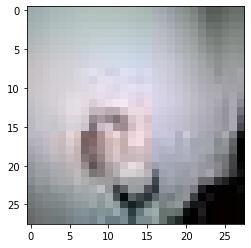

In [8]:
import random

# 학습 데이터 확인
n = random.randrange(0, 3299)

plt.imshow(x_train[n])
print('라벨: ', class_names[y_train[n]])

라벨:  가위


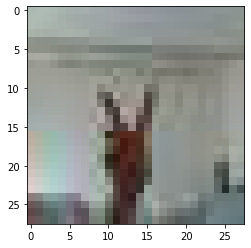

In [9]:
# 테스트 데이터 확인
n = random.randrange(0, 599)

plt.imshow(x_test[n])
print('라벨: ', class_names[y_test[n]])

## 2. 모델

### - 네트워크 설계

앞서 언급했듯 노드 학습 내용과 동일한 모델을 만들었다.

In [10]:
# 하이퍼파라미터
n_channel_1 = 32
n_channel_2 = 64
n_dense = 64
n_train_epoch = 10

In [11]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

Model에 추가된 Layer 개수:  7


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                102464    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

### - 학습

그래프를 그리기 위해 학습 내용을 h객체에 담아준다.

In [13]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

h = model.fit(x_train, y_train, epochs=n_train_epoch)

Epoch 1/10
104/104 [==============================] - 3s 4ms/step - loss: 1.0353 - accuracy: 0.4542
Epoch 2/10
104/104 [==============================] - 0s 3ms/step - loss: 0.7750 - accuracy: 0.6624
Epoch 3/10
104/104 [==============================] - 0s 3ms/step - loss: 0.5244 - accuracy: 0.8088
Epoch 4/10
104/104 [==============================] - 0s 3ms/step - loss: 0.3914 - accuracy: 0.8645
Epoch 5/10
104/104 [==============================] - 0s 3ms/step - loss: 0.2810 - accuracy: 0.9073
Epoch 6/10
104/104 [==============================] - 0s 3ms/step - loss: 0.2184 - accuracy: 0.9309
Epoch 7/10
104/104 [==============================] - 0s 3ms/step - loss: 0.1609 - accuracy: 0.9573
Epoch 8/10
104/104 [==============================] - 0s 3ms/step - loss: 0.1258 - accuracy: 0.9652
Epoch 9/10
104/104 [==============================] - 0s 3ms/step - loss: 0.0996 - accuracy: 0.9712
Epoch 10/10
104/104 [==============================] - 0s 3ms/step - loss: 0.0720 - accuracy: 0.9848

각 학습 단계의 정확도에 대해 그래프를 그려본다.

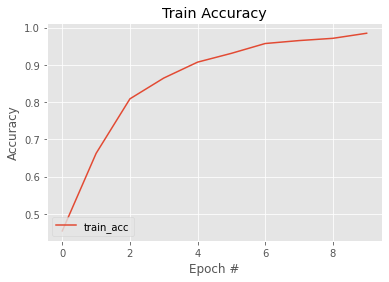

In [14]:
N = n_train_epoch    # 각 epoch 마다의 결과를 보기 위해

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), h.history["accuracy"], label="train_acc")
plt.title("Train Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

plt.savefig('train_accuracy.png')

## 3. 결과 확인 

### - 모델 평가

테스트 데이터를 이용하여 모델 성능을 평가해보자

In [15]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)

print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

19/19 - 0s - loss: 2.1890 - accuracy: 0.6567
test_loss: 2.1889803409576416 
test_accuracy: 0.6566666960716248


### * 정확도가 60% 넘었으므로 루브릭 평가 기준 달성 ᕕ( ՞ ᗜ ՞ )ᕗ

### - 잘못 예측한 경우

목표는 달성했지만 모델이 잘못 예측한 이미지를 눈으로 확인해보자!

In [16]:
predicted_result = model.predict(x_test)
predicted_labels = np.argmax(predicted_result, axis=1)

예측확률분포: [9.9686062e-01 3.0617875e-03 7.7648307e-05]
정답: 바위, 예측결과: 가위


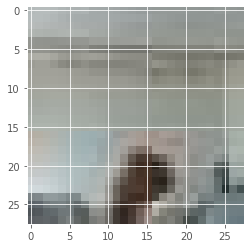

예측확률분포: [9.9966037e-01 2.6003204e-04 7.9548678e-05]
정답: 바위, 예측결과: 가위


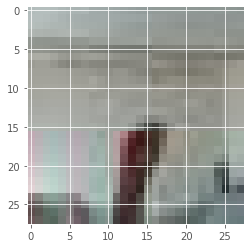

예측확률분포: [9.1957474e-01 8.0412507e-02 1.2803577e-05]
정답: 바위, 예측결과: 가위


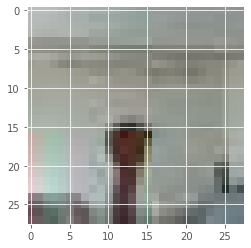

In [17]:
wrong_predict_list=[]

for i, _ in enumerate(predicted_labels):
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

samples = random.choices(population=wrong_predict_list, k=3)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("정답: " + class_names[y_test[n]] + ", 예측결과: " + class_names[predicted_labels[n]])
    plt.imshow(x_test[n], cmap=plt.cm.binary)
    plt.show()

1. 예측한 라벨과 정답이 같지 않은 경우만 wrong_predict_list에 모은다.
2. wrong_predict_list에서 랜덤으로 3개만 뽑아 확인한다.
3. 정답과 예측결과, 이미지를 출력한다.

## 4. 재학습

### - 하이퍼파라미터 조정

정확도를 높이기 위해 하이퍼파라미터를 조정해본다.

In [18]:
n_channel_1 = 64
n_channel_2 = 128
n_dense = 512
n_train_epoch = 12

In [19]:
model_2=keras.models.Sequential()
model_2.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model_2.add(keras.layers.MaxPool2D(2,2))
model_2.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model_2.add(keras.layers.MaxPooling2D((2,2)))
model_2.add(keras.layers.Flatten())
model_2.add(keras.layers.Dense(n_dense, activation='relu'))
model_2.add(keras.layers.Dense(3, activation='softmax'))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1638912   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

In [20]:
model_2.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model_2.fit(x_train, y_train, epochs=n_train_epoch)

Epoch 1/12
104/104 [==============================] - 1s 4ms/step - loss: 1.0742 - accuracy: 0.4185
Epoch 2/12
104/104 [==============================] - 0s 3ms/step - loss: 0.7697 - accuracy: 0.6530
Epoch 3/12
104/104 [==============================] - 0s 3ms/step - loss: 0.4797 - accuracy: 0.8094
Epoch 4/12
104/104 [==============================] - 0s 3ms/step - loss: 0.3535 - accuracy: 0.8727
Epoch 5/12
104/104 [==============================] - 0s 3ms/step - loss: 0.2554 - accuracy: 0.9058
Epoch 6/12
104/104 [==============================] - 0s 3ms/step - loss: 0.1790 - accuracy: 0.9358
Epoch 7/12
104/104 [==============================] - 0s 3ms/step - loss: 0.1367 - accuracy: 0.9552
Epoch 8/12
104/104 [==============================] - 0s 3ms/step - loss: 0.1174 - accuracy: 0.9594
Epoch 9/12
104/104 [==============================] - 0s 3ms/step - loss: 0.0707 - accuracy: 0.9788
Epoch 10/12
104/104 [==============================] - 0s 3ms/step - loss: 0.0521 - accuracy: 0.9818

In [21]:
test_loss, test_accuracy = model_2.evaluate(x_test, y_test, verbose=2)

print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

19/19 - 0s - loss: 2.3230 - accuracy: 0.6683
test_loss: 2.323021650314331 
test_accuracy: 0.6683333516120911


기존의 학습보다 약간 정확도가 높아졌다. (65.6% -> 66.8%)  
하지만 이렇게 소소한 변화로는 모델의 성능을 크게 높일 수 없는 듯 하다.

### - 레이어 추가

기존 모델에 레이어를 추가해본다.

In [22]:
n_channel_1 = 32
n_channel_2 = 64
n_channel_3 = 128
n_dense_1 = 512
n_dense_2 = 1024
n_train_epoch = 10

In [23]:
model_3=keras.models.Sequential()
model_3.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model_3.add(keras.layers.MaxPool2D(2,2))
model_3.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model_3.add(keras.layers.MaxPooling2D((2,2)))
model_3.add(keras.layers.Conv2D(n_channel_3, (3,3), activation='relu'))
model_3.add(keras.layers.MaxPooling2D((2,2)))
model_3.add(keras.layers.Flatten())
model_3.add(keras.layers.Dense(n_dense_1, activation='relu'))
model_3.add(keras.layers.Dropout(0.5))        # 과적합 방지를 위해
model_3.add(keras.layers.Dense(n_dense_2, activation='relu'))
model_3.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model_3.layers))

Model에 추가된 Layer 개수:  11


In [24]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)              

In [25]:
model_3.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model_3.fit(x_train, y_train, epochs=n_train_epoch)

Epoch 1/10
104/104 [==============================] - 1s 4ms/step - loss: 1.0845 - accuracy: 0.3761
Epoch 2/10
104/104 [==============================] - 0s 4ms/step - loss: 0.7974 - accuracy: 0.6297
Epoch 3/10
104/104 [==============================] - 0s 4ms/step - loss: 0.5449 - accuracy: 0.7836
Epoch 4/10
104/104 [==============================] - 0s 4ms/step - loss: 0.3361 - accuracy: 0.8764
Epoch 5/10
104/104 [==============================] - 0s 4ms/step - loss: 0.2653 - accuracy: 0.9024
Epoch 6/10
104/104 [==============================] - 0s 4ms/step - loss: 0.2214 - accuracy: 0.9139
Epoch 7/10
104/104 [==============================] - 0s 4ms/step - loss: 0.1277 - accuracy: 0.9524
Epoch 8/10
104/104 [==============================] - 0s 4ms/step - loss: 0.1163 - accuracy: 0.9555
Epoch 9/10
104/104 [==============================] - 0s 4ms/step - loss: 0.0794 - accuracy: 0.9733
Epoch 10/10
104/104 [==============================] - 0s 4ms/step - loss: 0.0856 - accuracy: 0.9673

In [26]:
test_loss, test_accuracy = model_3.evaluate(x_test, y_test, verbose=2)

print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

19/19 - 0s - loss: 1.9037 - accuracy: 0.6833
test_loss: 1.9036928415298462 
test_accuracy: 0.6833333373069763


레이어를 더 쌓는 것이 하이퍼파라미터만 조정하는 것 보다 효과가 크다. (65.6% -> 66.8% -> 68.3%)   
신경망을 깊게 쌓는 잘 쌓는 것이 중요한 것 같다.

### - 이미지 원본 사용

이미지를 28X28 크기가 아닌 원본인 224X224 크기를 사용하면 결과가 어떻게 바뀔까?   
이미지만 원본을 사용하고 모델은 input 사이즈만 조정해준다.

In [27]:
dataset_dir_path = "./dataset224"
test_dir_path = "./test_data224"

x_train2, y_train2 = load_data(dataset_dir_path, 224, 3300)
x_test2, y_test2 = load_data(test_dir_path, 224, 600)

x_train2 = x_train2 / 255.0
x_test2 = x_test2 / 255.0

print("x_train2 shape: {}".format(x_train2.shape))
print("x_test2 shape: {}".format(x_test2.shape))

x_train2 shape: (3300, 224, 224, 3)
x_test2 shape: (600, 224, 224, 3)


In [28]:
# 하이퍼파라미터는 첫번째 모델과 동일
n_channel_1 = 32
n_channel_2 = 64
n_dense = 64
n_train_epoch = 10

In [29]:
model_4=keras.models.Sequential()
model_4.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(224,224,3))) # 이미지 크기에 맞춰 변경
model_4.add(keras.layers.MaxPool2D(2,2))
model_4.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model_4.add(keras.layers.MaxPooling2D((2,2)))
model_4.add(keras.layers.Flatten())
model_4.add(keras.layers.Dense(n_dense, activation='relu'))
model_4.add(keras.layers.Dense(3, activation='softmax'))

In [30]:
model_4.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model_4.fit(x_train2, y_train2, epochs=n_train_epoch)

Epoch 1/10
104/104 [==============================] - 5s 39ms/step - loss: 0.8595 - accuracy: 0.6603
Epoch 2/10
104/104 [==============================] - 4s 38ms/step - loss: 0.2027 - accuracy: 0.9270
Epoch 3/10
104/104 [==============================] - 4s 38ms/step - loss: 0.0710 - accuracy: 0.9803
Epoch 4/10
104/104 [==============================] - 4s 38ms/step - loss: 0.0563 - accuracy: 0.9852
Epoch 5/10
104/104 [==============================] - 4s 38ms/step - loss: 0.0295 - accuracy: 0.9933
Epoch 6/10
104/104 [==============================] - 4s 37ms/step - loss: 0.0296 - accuracy: 0.9915
Epoch 7/10
104/104 [==============================] - 4s 38ms/step - loss: 0.0934 - accuracy: 0.9764
Epoch 8/10
104/104 [==============================] - 4s 37ms/step - loss: 0.0098 - accuracy: 0.9976
Epoch 9/10
104/104 [==============================] - 4s 38ms/step - loss: 0.0070 - accuracy: 0.9985
Epoch 10/10
104/104 [==============================] - 4s 37ms/step - loss: 0.0032 - accura

In [31]:
test_loss, test_accuracy = model_4.evaluate(x_test2, y_test2, verbose=2)

print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

19/19 - 1s - loss: 3.7340 - accuracy: 0.6650
test_loss: 3.734005928039551 
test_accuracy: 0.6650000214576721


앞선 두 시도 보다 효과가 더 적다. (65.6% -> 66.8% -> 68.3% -> 66.5%)  
사람의 눈은 28 크기의 이미지보다 224 크기의 이미지가 훨씬 더 구분하기 쉽지만, 신경망의 입장에서는 그렇지만은 않은 것 같다.  
가위바위보 정도의 간단한 이미지 분류기를 만들 때는 굳이 큰 이미지를 학습에 사용하지 않아도 될 것 같다.   
시간 대비 효율이 커보이지 않는다. 

## 5. 회고

#### (1) 데이터의 중요성  


현재의 결과를 내기 전까지 많은 시도들이 있었지만 역시 깨끗한 데이터가 정확도에 미치는 영향이 가장 컸다.   
데이터를 고르지 않고 현재와 비슷한 3000장 정도의 데이터로 학습을 진행하였을 때는 정확도가 40%를 겨우 넘었다.  
기꺼이 데이터를 공유해주신 동료들에겐 미안하지만 배경이 너무 화려한 데이터는 제외하고 학습을 진행했더니 비로소 루브릭 기준을 충족할 수 있었다.    
딥러닝에서 가장 중요한 것은 양질의 데이터를 얻는 것이라는 결론을 내렸다. 


#### (2) 전이 학습


3300장의 데이터가 신경망을 처음부터 학습 시키기에는 너무 적다는 생각에 해결 방법을 찾아보았다.  
전이 학습 : 데이터의 수가 적을 때 대량의 데이터로 이미 학습된 모델을 이용하여 특징을 추출하는 레이어의 일부를 사용하는 기법   
전이 학습이 어떤 의미인지는 알겠지만 아직 어떤 사전 학습 모델을 이용해야 할지는 잘 모르겠다. 이 부분은 앞으로 공부를 하며 알아가도록 하겠다. 


#### (3) 아직 해결되지 않은 궁금증


라벨은 왜 정수형으로 넣어주는가?  
numpy 자료형 중 문자열도 있기 때문에 라벨을 문자열로 행렬에 넣으려는 시도를 해보았으나 실패하였다.  
일단은 리스트에 라벨 순서대로 문자열을 넣어 출력을 할 때 한글로 라벨이 보이도록 했다.

## 6. 참고 자료


- ANTIALIAS : https://ko.wikipedia.org/wiki/%EC%9C%84%EC%8B%A0%ED%98%B8_%EC%A0%9C%EA%B1%B0


- 전이 학습 : https://choice-life.tistory.com/40